In [1]:
import os
import sys
import cv2
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
import numpy as np

sys.path.append('UFLDmodel')
from UFLDmodel.parsingnet import parsingNet
from UFLDmodel.dataloader import get_train_loader, get_test_loader

In [2]:
def process_cls(cls_label):
    """将56行4列的车道线x坐标值转变成图片"""
    cls_label_to_img = np.zeros((56,100),dtype = np.uint8)
    for i,row in enumerate(cls_label):
        for j in range(4):
            if row[j]==100:
                continue
            else:
                # 将[row[j]即x处的值变成j
                cls_label_to_img[i][row[j]] = j+1
    return cls_label_to_img

In [3]:
# 定义预测函数
def predict(data,model):
    for batch in data:
        """img, cls_label, seg_label
        img.shape torch.Size([n, 3, 288, 800])
        cls_label.shape torch.Size([n, 56, 4])
        seg_label torch.Size([n, 36, 100])
        output:group_cls, aux_seg
        group_cls torch.Size([n, 101, 56, 4])
        aux_seg torch.Size([n, 5, 36, 100])
        """
        img = batch[0]
        cls_label = batch[1].numpy()
        seg_label = batch[2].numpy()
        output = model(img)
        # model计算出来的值带有梯度不能直接转成numpy
        cls_pred = np.argmax(output[0].detach().numpy(),axis = 1)
        seg_pred = np.argmax(output[1].detach().numpy(),axis = 1)
        
        
        for r_gt,c_gt,s_gt,c_p,s_p in zip(img,cls_label,seg_label,cls_pred , seg_pred):
            print('-'*60)
            plt.figure()
            plt.subplot(231)
            plt.title('cls_label')   
            plt.imshow(process_cls(c_gt))
            
            plt.subplot(232)
            plt.title('seg_label')
            plt.imshow(s_gt)
            
            plt.subplot(233)
            plt.title('ground_truth')
            plt.imshow(r_gt.numpy().transpose(1, 2, 0))
            
            plt.subplot(234)
            plt.title('cls_pred')
            plt.imshow(process_cls(c_p))
            
            plt.subplot(235)
            plt.title('seg_pred')
            plt.imshow(s_p)
                        
            plt.subplot(236)
            plt.title('ground_truth')
            plt.imshow(r_gt.numpy().transpose(1, 2, 0))

            plt.show()
        break

In [4]:
batch_size = 2
data_root = r'E:\tusimple_0531'
griding_num = 100
dataset = 'Tusimple'
use_aux = True
distributed = False
backbone = '50'
num_lanes = 4
# 使用训练的数据进行可视化
train_loader, cls_num_per_lane = get_train_loader(batch_size, data_root, griding_num, dataset, use_aux,distributed)

In [5]:
data_root = r'E:\tusimple_0531'
model = parsingNet(pretrained=True, backbone=backbone,cls_dim = (griding_num+1,cls_num_per_lane, num_lanes),use_aux=use_aux)
pth_path = r'E:\CV实训班\名企CV\7\UFLD_GPU\save_pth\parsenet_100.pth'
model.load_state_dict(torch.load(pth_path))

<All keys matched successfully>

------------------------------------------------------------


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


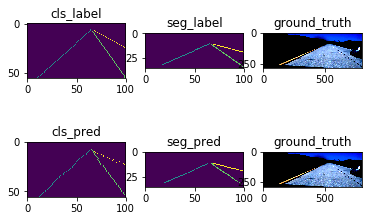

------------------------------------------------------------


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


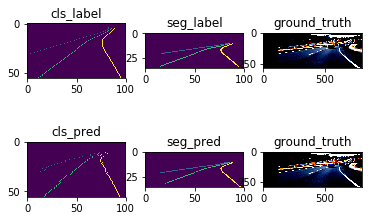

In [6]:
predict(train_loader,model)

In [7]:
batch_size = 4
data_root = r'E:\tusimple_0531'
dataset = 'Tusimple'
distributed = False
# 使用测试数据进行可视化
test_loader = get_test_loader(batch_size, data_root, dataset,distributed)

In [8]:
# 车道线的y值
y_anchor = np.array([ 64,  68,  72,  76,  80,  84,  88,  92,  96, 100, 104, 108, 112,
            116, 120, 124, 128, 132, 136, 140, 144, 148, 152, 156, 160, 164,
            168, 172, 176, 180, 184, 188, 192, 196, 200, 204, 208, 212, 216,
            220, 224, 228, 232, 236, 240, 244, 248, 252, 256, 260, 264, 268,
            272, 276, 280, 284])
def process_cls_to_coord(cls_label, img_shape):
    """将56行4列的cls转变成原图大小的坐标"""
    coordinate = []
    x_scale = img_shape[1]/100
    y_scale = img_shape[0]/288
    for i in range(4):
        cls_valid = np.where(cls_label[:,i] !=100)
        x = (cls_label[:,i][cls_valid]*x_scale).astype(np.int16)
        y = (y_anchor[cls_valid]*y_scale).astype(np.int16)
        # opencv画圆坐标先列后行
        coordinate.append(list(zip(x,y)))
    return coordinate

In [13]:
def test_show(test_loader,model):
    for batch in test_loader:
        """img, name
        img.shape torch.Size([n, 3, 288, 800])
        output:group_cls, aux_seg
        group_cls torch.Size([n, 101, 56, 4])
        aux_seg torch.Size([n, 5, 36, 100])
        """
        img = batch[0]
        img_name = batch[1]
        output = model(img)
        cls_pred = np.argmax(output[0].detach().numpy(),axis = 1)
        seg_pred = np.argmax(output[1].detach().numpy(),axis = 1)
        
        point_size = 4
        point_color = (0, 255, 0) 
        thickness = 4
        
        for row_name,c_p,s_p in zip(img_name,cls_pred,seg_pred):
            plt.figure()
            plt.subplot(1,3,1)
            show_img = cv2.imread(row_name)
            h,w,_ = show_img.shape
            plt.title('original_image')
            plt.imshow(cv2.cvtColor(show_img,cv2.COLOR_BGR2RGB))
#             plt.show()
            
            
            # 在坐标处绘制圆点，opencv用圆画点，中心坐标是先列后行
            plt.subplot(1,3,2)
            location = process_cls_to_coord(c_p, (h,w))
            cls_img = show_img.copy()
            for i in range(4):
                for co in location[i]:
                    cv2.circle(show_img, co, point_size, point_color, thickness)
            plt.title('cls_label')
            plt.imshow(show_img)
#             plt.show()

            # 将分割的结果映射到原图上
            plt.subplot(1,3,3)
            scale_seg = cv2.resize(s_p,(w,h),interpolation=cv2.INTER_NEAREST)
            nonzero_location = np.where(scale_seg != 0)
            new_img = show_img.copy()
            new_img[nonzero_location] = [0,255,0]
            plt.title('seg_label')
            plt.imshow(new_img)
            plt.tight_layout()
            plt.show()
        break
        

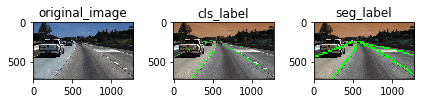

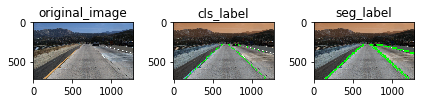

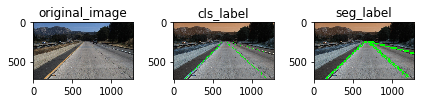

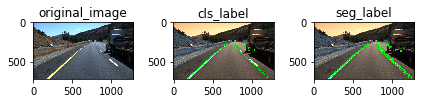

In [14]:
test_show(test_loader,model)